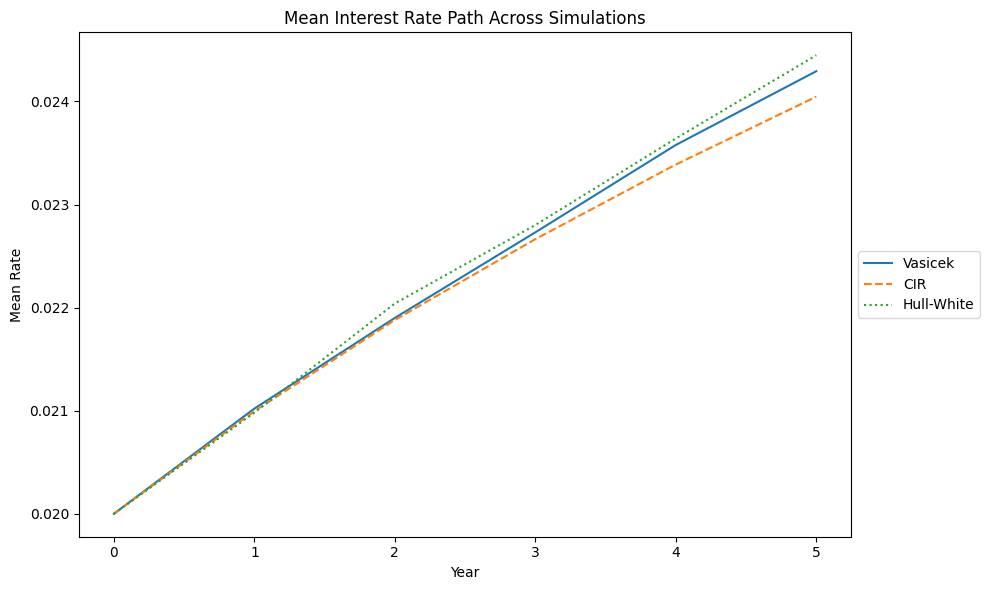

Vasicek swap value: 1.0066
CIR swap value: 1.1937
Hull-White swap value (with time-dependent theta): 1.0501


In [17]:
# This Python script demonstrates how to simulate short-term interest rates using three popular models in quantitative finance—Vasicek, CIR, and Hull-White—and how to use these simulated rates to price a simple fixed-for-floating interest rate swap using Monte Carlo methods.

import numpy as np
import matplotlib.pyplot as plt

# PARAMETERS
n_paths = 10000         # number of Monte Carlo paths
n_steps = 5             # number of yearly steps
T = 5                   # years
dt = 1.0                # time step size (years)
r0 = 0.02               # initial short rate

a = 0.1                 # mean reversion speed
b = 0.03                # long-term mean
sigma = 0.01            # volatility

# Vasicek model: dr = a(b - r)dt + sigma dW
def vasicek_paths(a, b, sigma, r0, n_steps, dt, n_paths):
    rates = np.zeros((n_paths, n_steps+1))
    rates[:,0] = r0
    for t in range(1, n_steps+1):
        dr = a * (b - rates[:,t-1]) * dt + sigma * np.sqrt(dt) * np.random.randn(n_paths)
        rates[:,t] = rates[:,t-1] + dr
    return rates

# CIR model: dr = a(b - r)dt + sigma sqrt(r) dW
def cir_paths(a, b, sigma, r0, n_steps, dt, n_paths):
    rates = np.zeros((n_paths, n_steps+1))
    rates[:,0] = r0
    for t in range(1, n_steps+1):
        dr = a * (b - rates[:,t-1]) * dt + sigma * np.sqrt(np.maximum(rates[:,t-1],0)) * np.sqrt(dt) * np.random.randn(n_paths)
        rates[:,t] = np.maximum(rates[:,t-1] + dr, 0)   # ensure rates stay non-negative
    return rates

# Hull-White model: dr = [theta(t) - a r] dt + sigma dW, theta(t) time dependent
def hull_white_paths(a, b, sigma, r0, n_steps, dt, n_paths):
    rates = np.zeros((n_paths, n_steps+1))
    rates[:,0] = r0
    # theta(t) = ab for flat forward curve
    theta = np.full(n_steps+1, a * b)
    for t in range(1, n_steps+1):
        dr = (theta[t] - a * rates[:,t-1]) * dt + sigma * np.sqrt(dt) * np.random.randn(n_paths)
        rates[:,t] = rates[:,t-1] + dr
    return rates

# SIMULATE PATHS
vasicek_rate = vasicek_paths(a, b, sigma, r0, n_steps, dt, n_paths)
cir_rate = cir_paths(a, b, sigma, r0, n_steps, dt, n_paths)
hw_rate = hull_white_paths(a, b, sigma, r0, n_steps, dt, n_paths)

# PLOT MEAN PATHS FOR EACH MODEL (instead of first 5 simulations)
plt.figure(figsize=(10,6))
years = np.arange(n_steps+1)
plt.plot(years, np.mean(vasicek_rate, axis=0), label='Vasicek')
plt.plot(years, np.mean(cir_rate, axis=0), label='CIR', linestyle='--')
plt.plot(years, np.mean(hw_rate, axis=0), label='Hull-White', linestyle=':')
plt.xlabel('Year')
plt.ylabel('Mean Rate')
plt.title('Mean Interest Rate Path Across Simulations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


# SIMPLE IR SWAP PRICING (fixed vs floating)
def price_swap(rates, fixed_rate=0.02):
    n_steps = rates.shape[1] - 1
    dt = 1.0
    notional = 100
    # Discount factors and cashflows
    df = np.exp(-np.cumsum(rates[:,1:], axis=1)*dt)
    fixed_leg = fixed_rate * notional * np.sum(df, axis=1)
    floating_leg = notional * np.sum(rates[:,1:] * df, axis=1)
    pv = np.mean(floating_leg - fixed_leg)
    return pv

vasicek_swap = price_swap(vasicek_rate)
cir_swap = price_swap(cir_rate)
hw_swap = price_swap(hw_rate)

print(f'Vasicek swap value: {vasicek_swap:.4f}')
print(f'CIR swap value: {cir_swap:.4f}')
print(f'Hull-White swap value (with time-dependent theta): {hw_swap:.4f}')
